In [1]:
import numpy as np
import pandas as pd

from collections import Counter                        
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score


Theory
-http://www.reirab.com/Teaching/AML23/4-logisticRegression.pdf


Paper on a team that made predictions. 
-https://arxiv.org/pdf/2304.00176.pdf


Implementation
-https://www.youtube.com/watch?v=wY3PJGZEyY4
-https://towardsdatascience.com/multiclass-logistic-regression-from-scratch-9cc0007da372
-https://fa.bianp.net/blog/2019/evaluate_logistic/
This happens because the two terms in 1 + np.exp(-z) are on very different scales. exp(-40) is of the order of 10−18. Since double precision can hold up to 17 significant decimal digits, the expression 1 + np.exp(-40) gets truncated to 1, a phenomenon known as round-off error in numerical analysis.


# Clean the raw data

In [2]:
raw_data= pd.read_csv('/Users/ceciliaacosta/IFT-6390-ml_fundamentals/classification-of-extreme-weather-events-udem/train.csv')
raw_data.shape

# training data
df=raw_data.drop(['SNo'], axis=1)

#check for duplicates
print(df.duplicated().values.any())

# check how many duplicates
print(df.duplicated().sum())

# drop duplicates
df=df.drop_duplicates()
# Calculate the mean and standard deviation for rows where 'Label' == 0

# Empty list to hold dataframes after filtering outliers for each label
dfs = []

# Loop through each unique label
for label in df['Label'].unique():
    
    # Split the data based on current label
    label_df = df[df['Label'] == label]
    
    # Compute upper and lower limits using only current label data
    mean_vals = label_df.mean()
    std_vals = label_df.std()
    upper_lim = mean_vals + 3 * std_vals
    lower_lim = mean_vals - 3 * std_vals
    
    # Filter out the 'Label' column from label_df for comparison
    
    filtered_label_df = label_df[label_df.columns.difference(['Label'])]

    # Create the mask using the limits
    mask = (filtered_label_df < upper_lim.reindex(filtered_label_df.columns)) & \
           (filtered_label_df > lower_lim.reindex(filtered_label_df.columns))
    
    # Apply the mask to label_df
    filtered_label_df = label_df[mask.all(axis=1)]

    # Append the filtered label dataframe to dfs list
    dfs.append(filtered_label_df)

# Concatenate all the filtered dataframes back together
df = pd.concat(dfs, axis=0)

# Optionally, reset the index
df = df.reset_index(drop=True)

# shuffle
df = df.sample(frac=1).reset_index(drop=True)


True
20759


There are 20759 duplicates in the data. Most of them are in the class 0 and 1 

# Prepare the data for training

- change the time data with sin and cos to make it cyclical, since seasonality is important in this data
- change the label data to one-hot encoding
- use min max scaler to scale the data, because the extreme values are important in this data and we don't want to lose them, so we don't use standard scaler, which will make the data to be normal distribution. 


In [127]:
#change the column of time to make it cyclical with cos and sin functions  
from datetime import datetime   

# test data 
test_data= pd.read_csv('/Users/ceciliaacosta/IFT-6390-ml_fundamentals/classification-of-extreme-weather-events-udem/test.csv')



# Function to check the date format
def check_format(date_str):
    try:
        # Convert the date into a datetime object
        date_str =str(date_str)
        datetime.strptime(date_str, '%Y%m%d')
        return True 
    except ValueError:
        return False
    

final_pred=test_data['SNo']
test_data1=test_data.copy()
test_data1=pd.DataFrame(test_data1)
test_data1=test_data1.drop('SNo', axis=1)
#transform the time column  
test_data1['time'] = test_data1['time'].astype(str)
# Apply the function to get a mask of rows that match the format
mask = test_data1['time'].apply(check_format)
# Convert only the valid dates to datetime
test_data1.loc[mask, 'time'] = test_data1.loc[mask, 'time'].apply(lambda x: datetime.strptime(x, '%Y%m%d'))
# Now, let's extract the day of year
test_data1['day_of_year'] = test_data1['time'].apply(lambda x: x.dayofyear if isinstance(x, datetime) else None)
#cyclical
days_in_year = 365.0

test_data1['day_of_year'].fillna(0, inplace=True)
test_data1['sin_day'] = np.sin(2 * np.pi * test_data1['day_of_year'] / days_in_year)
test_data1['cos_day'] = np.cos(2 * np.pi * test_data1['day_of_year'] / days_in_year)

test_data1=test_data1.drop(['time'], axis=1)
test_data1=test_data1.drop(['day_of_year'], axis=1)
#standardize the data except  the last two columns  
test_data1 = (test_data1 - test_data1.mean()) / test_data1.std()   


# Apply the function to the 'date' column to get a boolean mask
df['time'] = df['time'].astype(str)
mask = df['time'].apply(check_format)

# Use the mask to transform only the dates with the right format
df.loc[mask, 'time'] = df.loc[mask, 'time'].apply(lambda x: datetime.strptime(x, '%Y%m%d'))
# This step ensures that the entire 'time' column is treated as datetime, converting non-datetime entries to NaT
df['time'] = pd.to_datetime(df['time'], errors='coerce')
day_of_year = df['time'].dt.dayofyear

# Days in a year (considering non-leap years for simplicity)
days_in_year = 365.0
# Apply sin for cyclic encoding
df['sin_day'] = np.sin(2 * np.pi * day_of_year / days_in_year)
df['cos_day'] = np.cos(2 * np.pi * day_of_year / days_in_year)  


y=df['Label']
y=y.reset_index()
# transfrom  y into a pd.series
y=pd.Series(y['Label'])

#create a one hot encoding for the labels of y without any library:
one_hot_y = np.zeros((y.shape[0], len(np.unique(y))))
for i in range(len(y)):
    one_hot_y[i, y.get(i)] = 1
Y=one_hot_y


print(Counter(y))

Counter({0: 17099, 2: 4250, 1: 1033})


### scale the data depending on what is best 
min-max scaling: (x-min)/(max-min)
standard scaling: (x-mean)/std  

In [100]:
X=df.drop(['Label'], axis=1)
X=X.drop(['time'], axis=1)

#min max scaling
#X= X-X.min() / (X.max()-X.min())  
  
# standardization
X=(X-X.mean())/X.std()

X['sin_day']=df['sin_day']
X['cos_day']=df['cos_day']


### K-fold stratified function from scratch 

In [128]:
def manual_stratified_kfold(X, y, k):
    # Ensure X and y are pandas DataFrame and Series respectively
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)
    print(y.ndim)
    if not isinstance(y, pd.Series) and y.ndim == 1:
        y = pd.Series(y)
    elif not isinstance(y, pd.Series) and y.ndim != 1:
        raise ValueError("y should be a o|ne-dimensional array or a pandas Series.")

    # Calculate the number of samples from each class for each fold
    classes, class_counts = np.unique(y, return_counts=True)
    print(class_counts)
    samples_per_fold_per_class = np.floor(class_counts / k).astype(int)
    
    # Initialize folds
    folds = []
    
    for fold in range(k):
        fold_indices = []
        
        # For each class, randomly sample without replacement the calculated number of samples
        for class_label, samples_per_fold in zip(classes, samples_per_fold_per_class):
            class_indices = y[y == class_label].index
            fold_indices.extend(np.random.choice(class_indices, samples_per_fold, replace=False))
        
        # Ensure indices are unique for each fold
        fold_indices = list(set(fold_indices))
        
        # Get the indices not in the fold (remaining indices)
        remaining_indices = list(set(y.index) - set(fold_indices))
        
        # Split data into train and test for the fold
        X_train, X_test = X.loc[remaining_indices], X.loc[fold_indices]
        y_train, y_test = y.loc[remaining_indices], y.loc[fold_indices]
        
        folds.append((X_train, X_test, y_train, y_test))
    
    return folds

In [129]:
def calculate_class_weights(Y):
    """
    Calculate class weights based on the class distribution in the target labels Y.

    Args:
    Y (numpy.ndarray): The target labels (one-hot encoded).

    Returns:
    class_weights (list): A list of class weights for each class.
    """
    num_samples, num_classes = Y.shape
    class_weights = np.zeros(num_classes)
    class_freq = np.zeros(num_classes)

    for class_idx in range(num_classes):
        class_counts = np.sum(Y[:, class_idx])
        total_samples = num_samples
        class_weights[class_idx] = total_samples / (num_classes * class_counts)
        class_freq[class_idx] = class_counts/total_samples

    return class_weights, class_freq

We can see that there is a class imbalance
Therefore, we need to change weights to the loss function to account for this imbalance.

- https://machinelearningmastery.com/cost-sensitive-logistic-regression/#:~:text=Logistic%20regression%20does%20not%20support,the%20skewed%20distribution%20into%20account.

cross validation for imbalances classes: 

- https://machinelearningmastery.com/cross-validation-for-imbalanced-classification/ 


# Class for logistic regression 

In [130]:
class LR_mini_batch:
    def __init__(self, X, Y, test_X, class_weights, lambda_reg, class_distribution,L):
        self.X = np.column_stack((np.ones(X.shape[0]), X))  # (n, m + 1)
        self.Y=Y # one hot encoding (n,3)
        self.class_weights = class_weights # a vector
        self.lambda_reg = lambda_reg
        self.num_classes=Y.shape[1]
        self.convergence_metrics = []  # List to store convergence metrics (loss)
        self.weights = None  # Weights matrix
        self.class_distribution = class_distribution
        self.test_X=np.column_stack((np.ones(test_X.shape[0]), test_X))
        self.L=L
 
    #the logistic equation with arguments: vectors a and c
    def mini_batch_generator(self, X, Y, batch_size, label):
        num_classes = Y.shape[1]

        # Create a list of indices for each class
        class_indices = [np.where(Y[:, i] == 1)[0] for i in range(num_classes)]

        
        while True:
            batch_X = np.empty((batch_size, X.shape[1]))
            batch_Y = np.empty((batch_size, num_classes))

            for i in range(batch_size):
                if self.class_distribution[label] is not None and sum(self.class_distribution[label]) > 0:
                    class_idx = np.random.choice(num_classes, p=self.class_distribution[label])
                else:
                    class_idx = np.random.randint(num_classes)  # Randomly select a class
                    
                class_sample_indices = class_indices[class_idx]
                
                if len(class_sample_indices) == 0:
                    continue  # Skip this iteration if the class has no samples

                sample_idx = np.random.choice(class_sample_indices)
                batch_X[i] = X[sample_idx]
                batch_Y[i] = Y[sample_idx]

            yield batch_X, batch_Y



    def logEq(self, w, x):
        w = np.array(w, dtype=np.float64)
        x = np.array(x, dtype=np.float64)
        z = np.dot(w, x)
        # Clip for numerical stability

        
        z = np.clip(z, -100, 100)
        return 1 / (1 + np.exp(-z))

   
    def cross_entropy_loss_for_class(self, X, Y, class_idx, weights):
        epsilon = 1e-15  # Small value to prevent log(0) issues
        num_samples = X.shape[0]
        losses = np.zeros(num_samples)

        for i in range(num_samples):
            # Calculate the predicted probability for the current class
            predicted_prob = self.logEq(weights[class_idx], X[i, :])

            # Clip probability to avoid log(0) issues
            predicted_prob = np.clip(predicted_prob, epsilon, 1 - epsilon)

            # Calculate the cross-entropy loss for the current sample
            loss = -Y[i, class_idx] * np.log(predicted_prob) - (1 - Y[i, class_idx]) * np.log(1 - predicted_prob)
            losses[i] = loss

        # Calculate the average loss over all samples
        average_loss = np.mean(losses)
        return average_loss


    
    #update the weights for class 
    def fit(self,epsilon,max_iterations, learning_rate, batch_size, decay_rate):
    
        #initialize weights vector
                #initialize weights vector
        self.weights = np.random.randn(self.num_classes, self.X.shape[1])
        prev_loss = float('inf')

        
        for class_idx in range(0,self.num_classes):

            batch_gen = self.mini_batch_generator(self.X, self.Y, batch_size, class_idx)
            w=self.weights[class_idx]
            prev_w=np.full(self.X.shape[1],-100)
            self.convergence_metrics = []  # List to store convergence metrics (loss)
            k=0        
             
            while True:
     
                # initialize gradient vector
                direc=np.full(self.X.shape[1],0)
         
                for batch_X, batch_Y in batch_gen:
                    for i in range (0,batch_X.shape[0]):
                        direc = direc + batch_X[i, :]*(batch_Y[i, class_idx]-self.logEq(w,batch_X[i,:])) 
                    break 

                #regularization term Using L1 and L2 regularization 
                alpha=self.lambda_reg[1]

                lambda_= self.lambda_reg[0]

                if self.L== 'elastic':
                    regularization_term = alpha*lambda_ * np.sign(w) + (1-alpha)*lambda_* self.lambda_reg[1] * w

                
                #leave the bias term out of the regularization
                regularization_term[0]=0

                # Update the weights for the current class (with regularization)
                direc= direc - regularization_term 
                
                #current_learning_rate = learning_rate(k) / (1 + decay_rate * k)

                w = w + learning_rate(k)*direc
            
                # Update the weights for the current class       
                self.weights[class_idx] = w
   
                # Calculate the loss for the current weights
                loss = self.cross_entropy_loss_for_class(self.X, self.Y, class_idx, self.weights)
                self.convergence_metrics.append(loss)

                #Plot loss function
                if k % 400== 0 and k>0: 

                    plt.plot(self.convergence_metrics)
                    plt.xlabel('Iterations')
                    plt.ylabel('Loss')
                    plt.title(f"Class {class_idx}, Iteration {k}, Loss: {loss:.4f}")
                    plt.show()
                

                # Stopping criteria
                if (abs(prev_loss - loss) < epsilon and k >100) or k >= max_iterations:
                    print(f"Stopping criteria met for class {class_idx} at iteration {k}, loss diff: {prev_loss-loss:.6f}")
                    plt.plot(self.convergence_metrics)
                    plt.xlabel('Iterations')
                    plt.ylabel('Loss')
                    plt.title(f"Class {class_idx}, Iteration {k}, Loss: {loss:.4f}")
                    plt.show()
                    break

                # Update the previous loss
                prev_loss = loss

                k+=1

        print(f"Training complete for regularization parameter {self.lambda_reg}")

        return self.weights
        
    # predict the class for each row of the test data using Softmax
    def predict(self):
        # Get the predictions for each class
        pred= self.test_X @ self.weights.T
        pred= pd.DataFrame(pred)


        #----------- Softmax function ----------------
        # Add a column for the sum of the exponent of each row
        pred['sum']= np.sum(np.exp(pred), axis=1)#sum of exponent each row
        
        # Divide each row by the sum of the row
        pred.iloc[:, :-1] = pred.iloc[:, :-1].div(pred['sum'], axis=1)

        # Get the index of the max value
        pred['prediction'] = pred.iloc[:, :-1].idxmax(axis=1)

        # Drop the sum column
        pred= pred['prediction']
            
        return pred



# HYPER-PARAMETER TUNING: different regularizations of L2, with mini_batch, and different weights during the training of each class




In [1]:
def reg_values_combination(total, alpha):
    """
    Give combinations of regularization values to try. for elastic net, L1 and L2   
    """
    combination=[]
    for i in total:
        for j in alpha:
            combination.append([i,j])   
    return combination
        

In [2]:
def learning_rate(k):
    """
    Learning rate function
    """
    
    return 1/(k+1)

### Choose the regularization parameters, and the sampling proportion to be used in each mini-batch

In [ ]:
# Chpoose the class_distribution, we do not use the results from the calculate_class_weights function
weights_class, class_0=calculate_class_weights(Y)
class_0=[0.7, 0.10, 0.20]
class_1=[0.6, 0.15, 0.25]
class_2=[0.6, 0.10, 0.30]

class_distribution=[class_0, class_1, class_2]

#create a random search for regularization values
reg_value=[ 0.01, 0.1, 1]
alpha=[ 0.5, 0.75, 0.9, 1]


combination= reg_values_combination(reg_value, alpha)


print(combination)


#create a random search for regularization values


### exp 6 : 
- epsilon=  1e-3
- alpha decay =0.01
- weights=  class_0=[0.7, 0.10, 0.20], class_1=[0.6, 0.15, 0.25], class_2=[0.6, 0.10, 0.30] 
- batch= 45
- Reg=
reg_value=[ 0.01, 0.1, 1, 2, 3]
alpha=[ 0.5, 0.75, 0.9, 1]

### exp 7 : 
- epsilon=  1e-4
- alpha decay =0.25/ (1+k*0.1)
- weights=  class_0=[0.7, 0.10, 0.20], class_1=[0.6, 0.30, 0.10], class_2=[0.6, 0.10, 0.30] 
-batch= 45

In [ ]:
# enumerate the splits and summarize the distributions
accuracy_mini=[]
f1_mini=[]
f1_weighted_mini=[]


for idx, val_reg in enumerate(combination):
   #kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)
 
   for list_ in manual_stratified_kfold(X, y, 2):
      # split data into train and test sets
      train_X, test_X, train_y, test_y = list_[0], list_[1], list_[2], list_[3]
      
      train_y= pd.DataFrame(train_y)
      test_Y_real=pd.DataFrame(test_y)

   #-----------------TRAIN--------------------

      #create a one hot encoding for the labels of y without any library:
      one_hot_y = np.zeros((train_y.shape[0], len(np.unique(y))))
      for i in range(len(train_y)):
         one_hot_y[i, train_y.get(i)] = 1
      train_y=one_hot_y

      lr=LR_mini_batch(train_X, train_y, test_X, weights_class, combination[idx] , class_distribution, "elastic")
      
      weights=lr.fit(epsilon=1e-4, max_iterations=1,learning_rate=learning_rate , batch_size=45, decay_rate=0.1)
      
      pred=lr.predict() 

      #-----------------TEST--------------------
      test_Y_real = test_Y_real.values.ravel()

      f1_weigh= f1_score(test_Y_real, pred, average='weighted')
      f1_not= f1_score(test_Y_real, pred, average=None)  
      accuracy= np.mean(pred==test_Y_real)   

      print('accuracy:', accuracy, f"regularization value: [total_value, alpha]=", combination[idx], ' f1_scores_weighted:', f1_weigh, ' f1_score:',f1_not)
      
      f1_mini.append(f1_weigh)
      f1_weighted_mini.append(f1_not)

      print(Counter(pred), Counter(test_Y_real))

      accuracy_mini.append(accuracy)
      break
     



# PLOT THE RESULTS OF THE EXPERIMENTS   

[0.699525039580035, 0.7415215398716773, 0.6851929005916174, 0.7530205816181985, 0.7740188317640196, 0.7669360886592784, 0.7509374218815099, 0.715440379968336, 0.7609365886176152, 0.6758603449712524, 0.7059411715690359, 0.7392717273560536]
0        1
1        1
2        1
3        1
4        1
        ..
11996    1
11997    1
11998    1
11999    1
12000    1
Name: prediction, Length: 12001, dtype: int64
0        1
1        1
2        1
3        1
4        1
        ..
11996    1
11997    0
11998    1
11999    0
12000    1
Name: Label, Length: 12001, dtype: int64
Counter({0: 9176, 2: 2637, 1: 188})
Counter({0: 9031, 2: 2424, 1: 546})


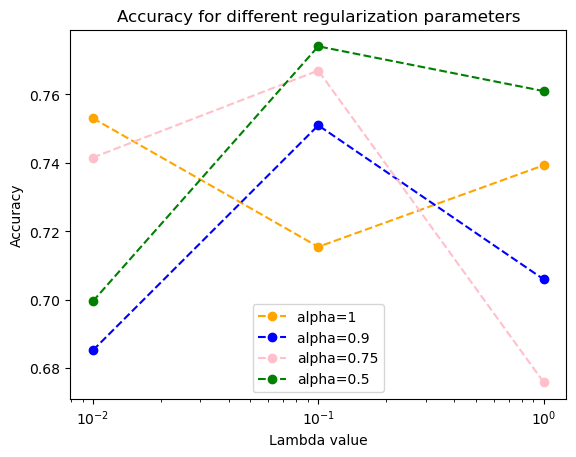

In [53]:
print(accuracy_mini)
print(pred)
print(test_Y_real['Label'])
print(Counter(pred))
print(Counter(test_Y_real['Label']))


#plot the accuracy for each regularization parameter for the two types of sampling
fig, ax = plt.subplots()
ax.plot([combination[j-1][0] for j in range (1, len( combination)+1) if j%4==0] , [accuracy_mini[j-1] for j in range (1, len( accuracy_mini)+1) if j%4==0], label='alpha=1 ', color='orange', linestyle='dashed', marker='o')
ax.plot([combination[j-1][0] for j in range (1, len( combination)+1) if j%4==3] , [accuracy_mini[j-1] for j in range (1, len( accuracy_mini)+1) if j%4==3], label='alpha=0.9 ', color='blue', linestyle='dashed', marker='o')
ax.plot([combination[j-1][0] for j in range (1, len( combination)+1) if j%4==2] ,[accuracy_mini[j-1] for j in range (1, len( accuracy_mini)+1) if j%4==2], label='alpha=0.75', color='pink', linestyle='dashed', marker='o')
ax.plot([combination[j-1][0] for j in range (1, len( combination)+1)  if j%4==1] , [accuracy_mini[j-1] for j in range (1, len( accuracy_mini)+1) if j%4==1], label='alpha=0.5', color='green', linestyle='dashed', marker='o')

ax.set_xlabel('Lambda value')

ax.set_ylabel('Accuracy')
ax.legend()
ax.set_xscale('log')

plt.title('Accuracy for different regularization parameters')
plt.savefig('mini_batch.png')
plt.show()


# f1 only on the last prediction 

[0.5730669566449267, 0.5515213251685983]


Text(0.5, 1.0, 'Mean weighted F1 score for different regularization parameters')

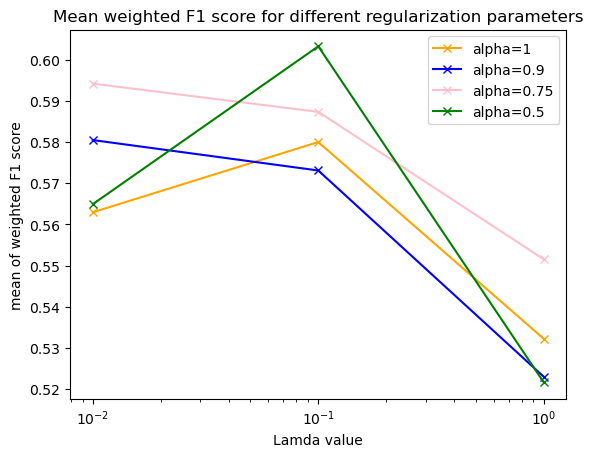

In [52]:

print([np.mean(f1_weighted_mini[i-1]) for i in range(1, len(f1_weighted_mini)) if i%5==0])

fig, ax = plt.subplots()
ax.plot([combination[j-1][0] for j in range (1, len( combination)+1)  if j%4==0], [np.mean(f1_weighted_mini[i-1]) for i in range(1, len(f1_weighted_mini)+1) if i%4==0], label='alpha=1', color='orange', linestyle='-', marker='x')
ax.plot([combination[j-1][0] for j in range (1, len( combination)+1)  if j%4==1], [np.mean(f1_weighted_mini[i-1]) for i in range(1, len(f1_weighted_mini)+1)if i%4==1], label='alpha=0.9', color='blue', linestyle='-', marker='x')
ax.plot([combination[j-1][0] for j in range (1, len( combination)+1)  if j%4==2], [np.mean(f1_weighted_mini[i-1]) for i in range(1, len(f1_weighted_mini)+1)if i%4==2], label='alpha=0.75', color='pink', linestyle='-', marker='x')
ax.plot([combination[j-1][0] for j in range (1, len( combination)+1)  if j%4==3], [np.mean(f1_weighted_mini[i-1]) for i in range(1, len(f1_weighted_mini)+1)if i%4==3], label='alpha=0.5', color='green', linestyle='-', marker='x')


ax.set_xscale('log')

#set the x axis to be in log scale
ax.set_xlabel('Lamda value')
ax.set_ylabel('mean of weighted F1 score')
ax.legend()


plt.title('Mean weighted F1 score for different regularization parameters')


# PREDICTIONS ON THE TEST SET

## 75.9 % on the test set 

In [ ]:
weights_class=[1,1,1]
class_0=[0.7, 0.10, 0.20]
class_1=[0.6, 0.20, 0.20]
class_2=[0.6, 0.15, 0.25]

class_distribution=[class_0, class_1, class_2]
print(test_data1.columns)    

add = np.ones((test_data1.shape[0], 1))
test_data= np.hstack((add, test_data1))

print(test_data.shape)
print(X.shape)


lr=LR_mini_batch(X, Y, test_data, weights_class, [0.1, 0.5], class_distribution, "elastic")
weights=lr.fit(1e-5, 400, learning_rate=learning_rate, batch_size=45, decay_rate=0.2)
pred=lr.predict(test_data)  
pred=pd.DataFrame(pred)


In [ ]:
#print every thing in pred to a csv file
pred.to_csv('pred_minibatchL2_exp7.csv', index=False)


# test data 
test_data= pd.read_csv('/Users/ceciliaacosta/IFT-6390-ml_fundamentals/classification-of-extreme-weather-events-udem/test.csv')
#create a new array that has the Sno column and the Label columns which are the predictions other than final_pred
final_pred=test_data['SNo']

final_pred=pd.concat([final_pred, pred], axis=1  )
final_pred.columns=['SNo', 'Label']


final_pred.to_csv('submission_minibatchL2_exp7.csv', index=False)

# Accuracy of 74.5% on the test set

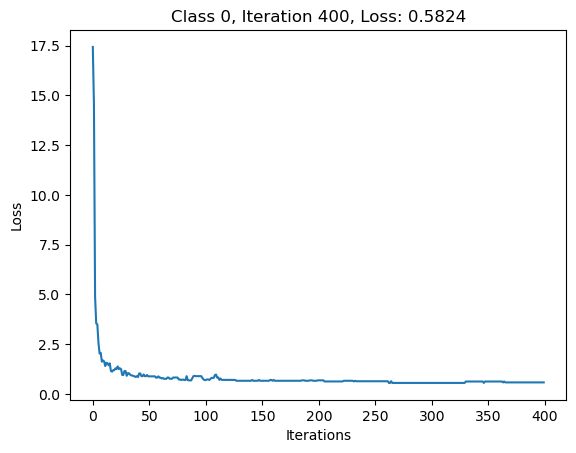

Class 0, Iteration 400, Loss: 0.5824


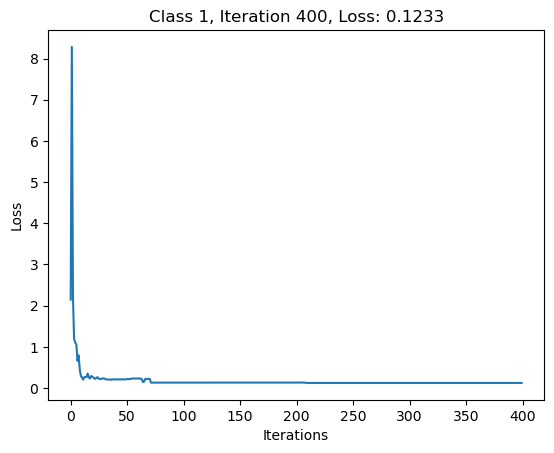

Class 1, Iteration 400, Loss: 0.1233


/var/folders/sk/v4vrhsvs23x5m4l_yhw9ckjw0000gn/T/ipykernel_23709/3705316319.py:51: RuntimeWarning: overflow encountered in exp
  le=1/(1+np.exp(np.dot(-self.a, self.c)))


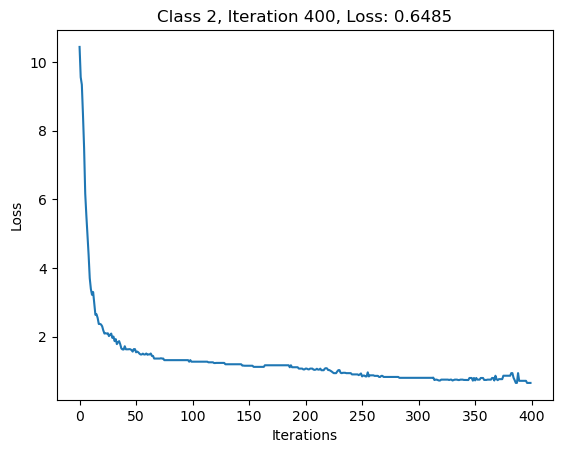

Class 2, Iteration 400, Loss: 0.6485


In [12]:
class_0=[0.7, 0.15, 0.15]
class_1=[0.5, 0.25, 0.25]
class_2=[0.5, 0.25, 0.25]
class_distribution=[class_0, class_1, class_2]
test_data=pd.DataFrame(test_data)
class_weights = [1, 1, 1]
final_pred=test_data['SNo']
test_data1=test_data.copy()
test_data1=test_data1.drop('SNo', axis=1)
test_data1= (test_data1 - np.mean(test_data1, axis=0))/np.std(test_data1, axis=0)

lr=LR_mini_batch(X, Y, test_data1, class_weights, 0.0001, class_distribution,  "L2")
weights=lr.fit(0.000001, 400, f)
pred=lr.predict()
final_pred= pd.concat([final_pred, pred], axis=1)
final_pred.columns=['SNo', 'Label']
final_pred.to_csv('submission_minibatchL2_exp4.csv', index=False)
